In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [2]:
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet_model = model.signatures['serving_default']

In [3]:
# Draw a circle with blue line borders of thickness of 2 px
#image = cv2.circle(image, center_coordinates, radius, color, thickness)
circle_colors = (0,255,0)
circle_thickness = -1
circle_radius = 4

In [4]:
# Draw Edges

KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

EDGES = {
    (0, 2): (255,0,0),
    (2, 4): (255,0,0),
    (1, 3): (255,0,0),
    (3, 5): (255,0,0),
    (0, 1): (255,0,0),
    (0, 6): (255,0,0),
    (1, 7): (255,0,0),
    (6, 7): (255,0,0),
    (6, 8): (255,0,0),
    (8, 10): (255,0,0),
    (7, 9): (255,0,0),
    (9, 11): (255,0,0)
}

In [5]:
def calculate_angle(a,b,c):
    a = np.array(a[:2]) # First
    b = np.array(b[:2]) # Mid
    c = np.array(c[:2]) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
#     if angle >180.0:
#         angle = 360-angle
        
    return angle 

In [6]:
def _model_predict(img):
    
    # Resize image
    img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 192,256)
    input_img = tf.cast(img, dtype=tf.int32)
    print(input_img.shape)
    
    # Detection
    results = movenet_model(input_img)
    
    # Reshape 
    keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
    
    # Selecting points
    new_keypoints_with_scores = _select_features(keypoints_with_scores)
    
    return new_keypoints_with_scores

In [7]:
def draw_lines_circle(im, sides, place, draw = True):
    shoulder = sides[0]
    elbow = sides[1]
    wrist = sides[2]
    y1, x1, c1 = shoulder
    y2, x2, c2 = elbow
    y3, x3, c3 = wrist
    
    ang = calculate_angle(shoulder[:2], elbow[:2], wrist[:2])
    if draw:
        im = cv2.circle(im, (int(x1), int(y1)), 1, (0,255,0), -1)
        im = cv2.circle(im, (int(x2), int(y2)), 1, (0,255,0), -1)
        im = cv2.circle(im, (int(x3), int(y3)), 1, (0,255,0), -1)
        
        im = cv2.line(im, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 1)
        im = cv2.line(im, (int(x3), int(y3)), (int(x2), int(y2)), (0,0,255), 1)
        
        im = cv2.putText(im, str(int(ang)), place, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)
        
    return im, int(ang)

In [8]:
def draw_circle(image, coord, confidence_threshold = 0.1):
    for kp in coord:
        ky, kx, kp_conf = kp
        print(kp)
        if kp_conf > confidence_threshold:
            image = cv2.circle(image, (int(kx), int(ky)), circle_radius, circle_colors, circle_thickness)
    return image

In [9]:
def draw_lines(image, coord, edges, confidence_threshold = 0.1):
    
    for edge, color in edges.items():

        p1, p2 = edge
        y1, x1, c1 = coord[p1]
        y2, x2, c2 = coord[p2]


        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(image, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 1)
            
    return image

In [10]:
right_shoulder = [1]
right_elbow = [3]
right_wrist = [5]
right_hip = [7]
right_knee = [9]
right_ankle = [11]

left_shoulder = [0]
left_elbow = [2]
left_wrist = [4]
left_hip = [6]
left_knee = [8]
left_ankle = [10]

features = [()]

In [11]:
# Draw Keypoints

def draw_keypoints(img, keypoint, edge, confidence_threshold = 0.1):
    
    y, x, c = img.shape
    coordinates_with_score = np.squeeze(np.multiply(keypoint, [y,x,1]))
    temp_img = img
    temp_img = draw_circle(temp_img, coordinates_with_score)
    temp_img = draw_lines(temp_img, coordinates_with_score, edge)
    
    shoulder = coordinates_with_score[0]
    elbow = coordinates_with_score[2]
    wrist = coordinates_with_score[4]
    
    ang = calculate_angle(shoulder, elbow, wrist)
    print(ang)
    
    
#     feat
    
#     right = [shaped[5], shaped[7], shaped[9]]
#     left = [shaped[6], shaped[8], shaped[10]]
    
#     right_side = [shaped[7], shaped[5], shaped[11]]
#     left_side = [shaped[8], shaped[6], shaped[12]]
    
    
#     temp_frame, angle1 = draw_lines_circle(temp_img, right, (100, 220))
#     temp_frame, angle2 = draw_lines_circle(temp_img, left, (100, 240))
#     temp_frame, angle3 = draw_lines_circle(temp_img, right_side, (100, 260))
#     temp_frame, angle4 = draw_lines_circle(temp_img, left_side, (100, 280))     
    return temp_img

In [12]:
def _select_features(all_keypoints):
    
    person = all_keypoints[0]  # model predicts upto 6 people, taking 1st predictions
    new_keypoints = person[5:] # taking from left_shoulder to right_ankle, removing head points
    
    return new_keypoints

(1, 192, 256, 3)
[ 93.51120432 333.1577301    0.72412854]
[110.29265201 262.90111542   0.87321186]
[ 81.72493312 382.58728027   0.41791853]
[130.73306999 254.71597672   0.73173094]
[1.16082847e+02 4.36468544e+02 2.41485849e-01]
[1.34135677e+02 2.06833744e+02 1.63688347e-01]
[219.82263386 341.57840729   0.84414715]
[222.88255328 289.80922699   0.90911001]
[276.28318262 409.37072754   0.77560633]
[286.77375317 214.01754379   0.8617537 ]
[355.87715179 465.65128326   0.89225507]
[335.18928468 136.94170952   0.51926094]
134.06447392129868


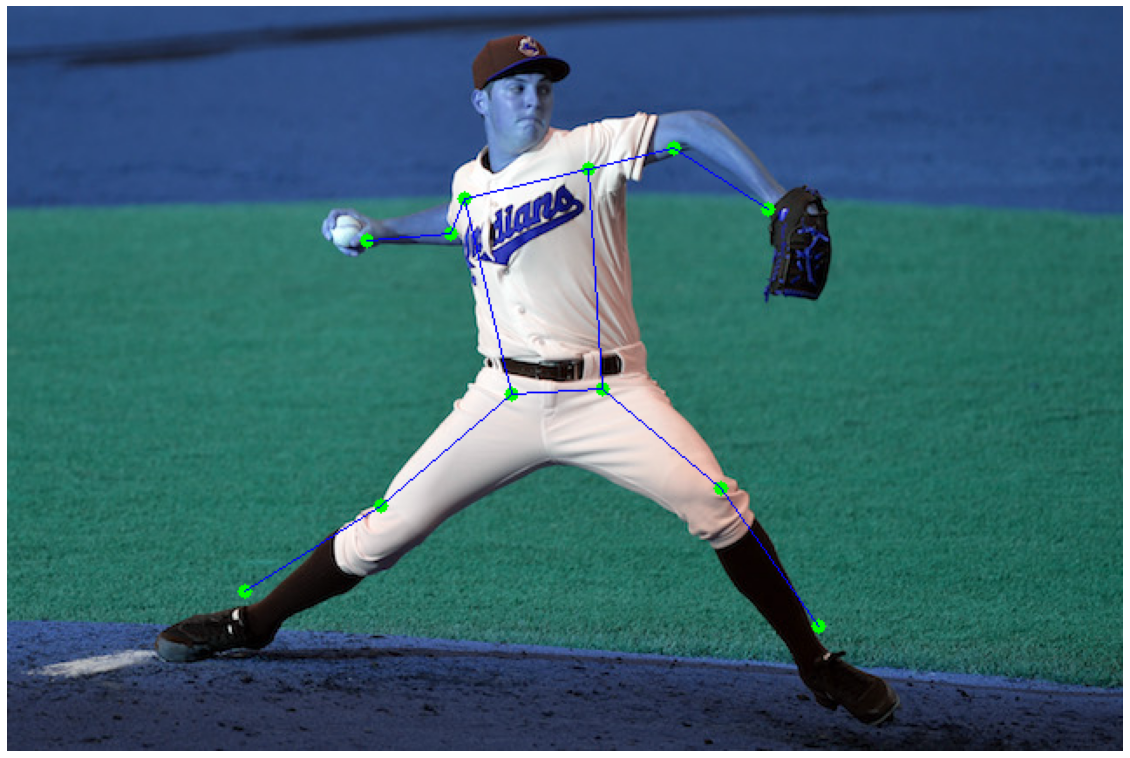

In [13]:
frame = cv2.imread('human2.jpg')

keypoints = _model_predict(frame)
# Render keypoints
new_frame = draw_keypoints(frame, keypoints, EDGES)

#plt.show('Movenet Multipose', frame)
plt.figure(figsize=(20, 20))
plt.imshow(new_frame)
_ = plt.axis('off')